In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import zray 
#import gpoidal.kernel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
import cv2


cv2.__version__



'4.6.0'

# Import Required Libraries
This cell imports the necessary libraries for the project, including:
- `numpy` for numerical computations
- `matplotlib.pyplot` for plotting
- `zray` for ray tracing and vessel modeling

## Set model by loading from dxf file

LineSegment(p0=(0.32, 0.075), p1=(0.2381534156157, 0.075))
LineSegment(p0=(0.375, -0.02), p1=(0.375, 0.02))
LineSegment(p0=(0.2381534156157, -0.075), p1=(0.32, -0.075))
LineSegment(p0=(0.0891, -0.6518687916845001), p1=(0.0891, 0.465))
LineSegment(p0=(0.1041, 0.48), p1=(0.493500000002, 0.48))
LineSegment(p0=(0.4935000000019, 0.48), p1=(0.4935000000019, 0.6568642520624001))
LineSegment(p0=(0.5269999999967, -0.6668687916845), p1=(0.103940112851, -0.6668687916845))
LineSegment(p0=(1.0000000000061, 0.3500015496597), p1=(1.0000000000061, -0.3500015496562))
LineSegment(p0=(0.4935000000019, 0.6568642520624001), p1=(0.5084705508735, 0.6718348029339001))
LineSegment(p0=(0.0891, 0.465), p1=(0.1041, 0.48))
LineSegment(p0=(0.0891, -0.6518687916845001), p1=(0.103940112851, -0.6668687916845))
CircularArc(center=(0.3, 0.0), radius=0.12, theta_start=162.0797868606, theta_end=197.9202131394)
CircularArc(center=(0.2381534156157, 0.02), radius=0.055, theta_start=90.0, theta_end=162.0797868606)
CircularArc

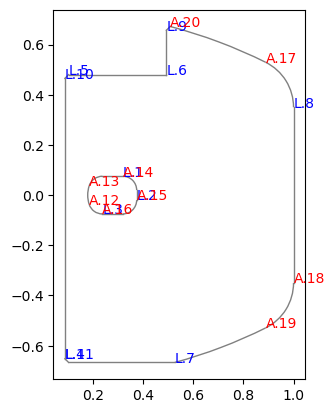

In [5]:
rt1_vessel = zray.AxisymmetricVessel.load_from_dxf('simplest0.dxf')
print(rt1_vessel)

fig,ax = plt.subplots()
rt1_vessel.plot(label=True, ax=ax)
ax.set_aspect('equal')

Arcs  detection: 100%|██████████| 9/9 [00:00<00:00, 328.53it/s]


fill_start_point is None, so use (0.5, 1.7763568394002505e-17)


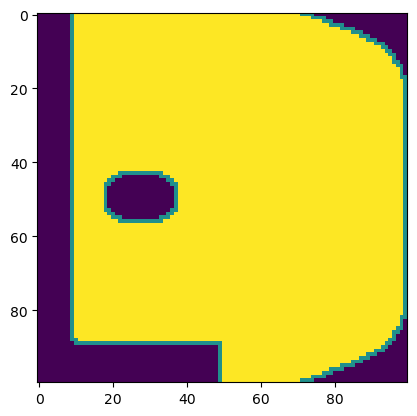

In [25]:
r_grid = np.linspace(0, 1, 100)
z_grid = np.linspace(-0.6, 0.6, 100)

rt1_vessel.detect_grid(r_grid, z_grid,static=True)
plt.imshow(rt1_vessel.fill)

## set 2Dcamera configration
we supoprt 2 type of setting: Camera2D_xyz and Camera2D_rphiz.

In [33]:
camera = zray.measurement.Camera2D_xyz(
    location=(4, 0.0, 1.6),   # 例：x=150 の位置
    direction=(-1.0, 0., -.45),     # 中心軸は負の x 方向
    sensor_size=(0.036, 0.024),                 # センサーサイズ [mm]（例）
    resolution=(300, 200),                      # 解像度
    focal_length=0.06,                         # 焦点距離 [mm]（例）
    rotation= 0,                          # センサーの回転角度
)

camera2 = zray.measurement.Camera2D_rphiz(
    focal_length=0.0063 ,                        # 焦点距離 [m]（例）
    location=(1.18, 0.0, 0),   # 例：x=150 の位置
    center_angles=(23.601,-1.6),
    sensor_size=( 0.004968,0.00373),                 # センサーサイズ [mm]（例）
    resolution=(300, 200),                      # 解像度
)

focal_length: 0.0063
sensor_size: (0.004968, 0.00373)
resolution: (300, 200)
location: [1.18 0.   0.  ]
center_angles: (23.601, -1.6)
rotation: 0
im_shape: (200, 300)
_Camera2D_rphiz__M: 60000


## Line camera 
LineCamera object can be used when sensor are consist of 1 dimentional array.

In [172]:
theta = np.arctan(0.45/1)

IF1  = zray.measurement.LineCamera(
    location=(1.01, 0, 0.0),   # 例：x=150 の位置
    direction=(-np.cos(theta), np.sin(theta), 0),     # 中心軸は負の x 方向
    sensor_size=(0.01),                 # センサーサイズ [m]（例）
    resolution=5,                      # 解像度
    focal_length=0.06,                         # 焦点距離 [m]（例）
)


IF2  = zray.measurement.LineCamera(
    location=(0.75, 0.0, 0.8),   # 例：x=150 の位置
    direction=(0.0, 0., -1),     # 中心軸は負の x 方向
    sensor_size=(0.01),                 # センサーサイズ [m]（例）
    resolution=5,                      # 解像度
    focal_length=0.06,                         # 焦点距離 [m]（例）
)


IF3  = zray.measurement.LineCamera(
    location=(0.6, 0.0, 0.8),   # 例：x=150 の位置
    direction=(0.0, 0., -1),     # 中心軸は負の x 方向
    sensor_size=(0.01),                 # センサーサイズ [m]（例）
    resolution=5,                      # 解像度
    focal_length=0.06,                         # 焦点距離 [m]（例）
)


focal_length: 0.06
location: [1.01 0.   0.  ]
direction: [-0.91192151  0.41036468  0.        ]
sensor_size: 0.01
resolution: 5
_LineCamera__M: 5
focal_length: 0.06
location: [0.75 0.   0.8 ]
direction: [ 0.  0. -1.]
sensor_size: 0.01
resolution: 5
_LineCamera__M: 5
focal_length: 0.06
location: [0.6 0.  0.8]
direction: [ 0.  0. -1.]
sensor_size: 0.01
resolution: 5
_LineCamera__M: 5


MultiCamera object is used when integratign cameras such as LineCamera or camera2D.

In [173]:
IF_sum = zray.measurement.MultiCamera([IF1,IF2,IF3])

print(IF_sum)


['camera0', 'camera1', 'camera2']
camera0
focal_length: 0.06
location: [1.01 0.   0.  ]
direction: [-0.91192151  0.41036468  0.        ]
sensor_size: 0.01
resolution: 5
_LineCamera__M: 5
camera1
focal_length: 0.06
location: [0.75 0.   0.8 ]
direction: [ 0.  0. -1.]
sensor_size: 0.01
resolution: 5
_LineCamera__M: 5
camera2
focal_length: 0.06
location: [0.6 0.  0.8]
direction: [ 0.  0. -1.]
sensor_size: 0.01
resolution: 5
_LineCamera__M: 5


In [174]:
## Calculating the ray where 

In [175]:
model = zray.main.Raytracing(rt1_vessel, IF_sum)
model.main(nreflections=1,pass_through_first=True)

[ 0.  0. -1.]
[-0.004 -0.002  0.     0.002  0.004]
[[ 0.95528471  0.02462188  0.004     ]
 [ 0.95528471  0.02462188  0.002     ]
 [ 0.95528471  0.02462188  0.        ]
 [ 0.95528471  0.02462188 -0.002     ]
 [ 0.95528471  0.02462188 -0.004     ]]
[ 1. -0.  0.]
[-0.004 -0.002  0.     0.002  0.004]
[[0.746 0.    0.74 ]
 [0.748 0.    0.74 ]
 [0.75  0.    0.74 ]
 [0.752 0.    0.74 ]
 [0.754 0.    0.74 ]]
[ 1. -0.  0.]
[-0.004 -0.002  0.     0.002  0.004]
[[0.596 0.    0.74 ]
 [0.598 0.    0.74 ]
 [0.6   0.    0.74 ]
 [0.602 0.    0.74 ]
 [0.604 0.    0.74 ]]


100%|██████████| 20/20 [00:00<?, ?it/s]


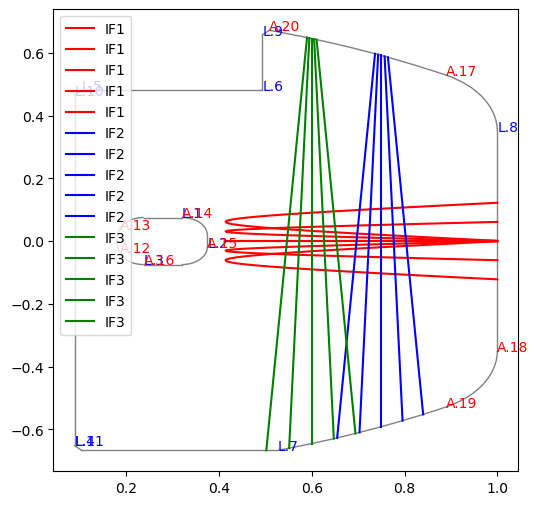

In [178]:
r,z = model.rays[1].generate_rz()
r.shape


fig,ax = plt.subplots(figsize=(6,6))
rt1_vessel.plot(label=True, ax=ax)
cmap = plt.get_cmap("tab10")



_slice = IF_sum.slice(0)
ax.plot(r[_slice,:].T,z[_slice,:].T, color='red', label=f'IF1')

_slice = IF_sum.slice(1)
ax.plot(r[_slice,:].T,z[_slice,:].T, color='blue', label=f'IF2')

_slice = IF_sum.slice(2)
ax.plot(r[_slice,:].T,z[_slice,:].T, color='green', label=f'IF3')


plt.legend()


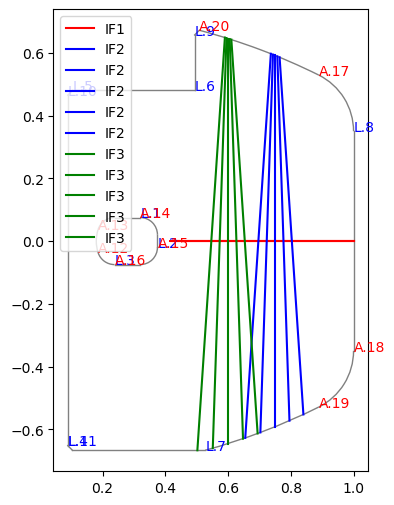

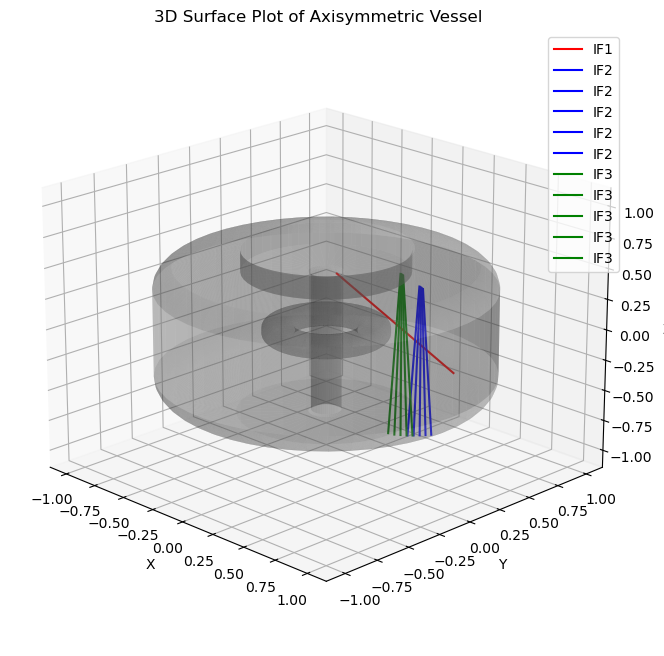

In [ ]:
r,z = model.rays[1].generate_rz()
r.shape


fig,ax = plt.subplots(figsize=(6,6))
rt1_vessel.plot(label=True, ax=ax)
cmap = plt.get_cmap("tab10")

ax.plot(r[0],z[0], color="red", label='IF1')
for i in range(1,6):
    ax.plot(r[i],z[i], color='blue', label=f'IF2')

for i in range(6,11):
    ax.plot(r[i],z[i], color='green', label=f'IF3')

ax.set_aspect('equal')
ax.legend()
plt.show()
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
rt1_vessel.plot_3d_surface(start_angle=0, end_angle=360, num_points=50, ax=ax,color='gray', alpha=0.3)

x,y,z = model.rays[1].generate_xyz()
ax.plot3D(x[0],y[0],z[0], color='red', label='IF1')
for i in range(1,6):
    ax.plot3D(x[i],y[i],z[i], color='blue', label=f'IF2')
for i in range(6,11):
    ax.plot3D(x[i],y[i],z[i], color='green', label=f'IF3')

ax.view_init(elev=20, azim=-45)
ax.legend()

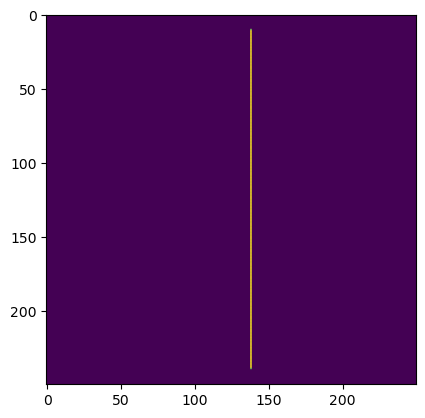

In [78]:
r_grid = np.linspace(0.1,1,250) 
z_grid = np.linspace(-0.7,0.7,250)

R,Z = np.meshgrid(r_grid,z_grid)

H = model.rays[1].generate_projectionmatrix_from_grid(r_grid,z_grid,Lnum=10001)

H2 = H.reshape(3,250,250)

plt.imshow(H2[2])

In [79]:
model2 = zray.main.Raytracing(rt1_vessel, camera)
model2.save_setting('model.json')
model2.main(nreflections=3)

100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


inf length is detected 19374


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


inf length is detected 20728


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


inf length is detected 20728


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


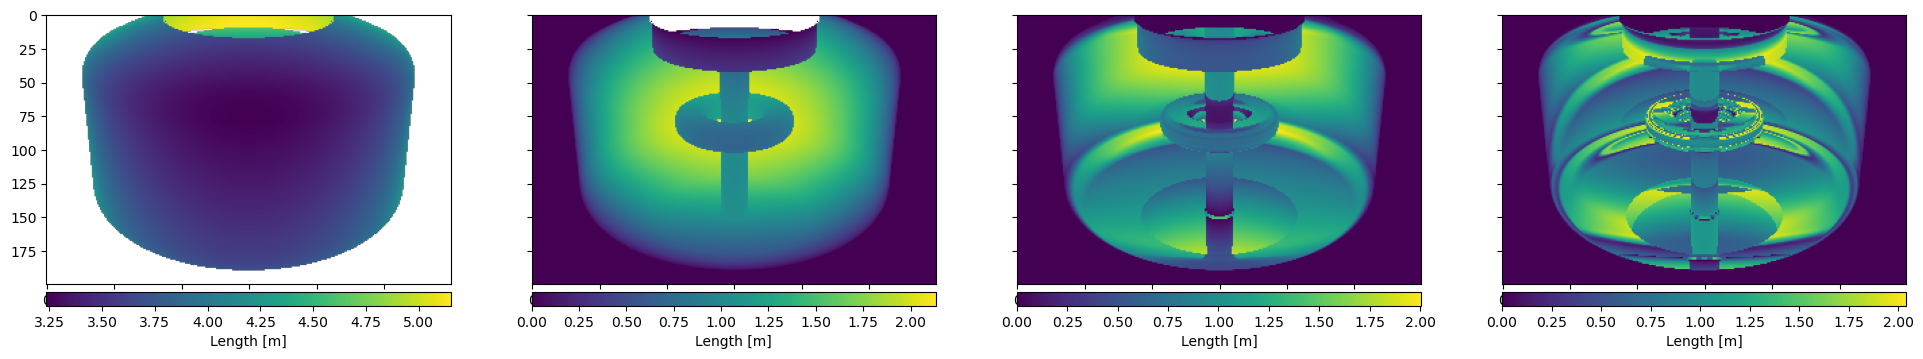

In [80]:
fig,axs = plt.subplots(1,4,figsize=(4*6,5), sharex=True, sharey=True)

for i,ray in enumerate(model2.rays):
    L = ray.Length

    zray.main.imshow_cbar_bottom(axs[i], L.im,cbar_title="Length [m]")

In [60]:
model2.save_heavy_model('heavy_model')